# <center> [🧪 ClearML: Advanced level](https://stepik.org/lesson/1517892?unit=1538174)

## 📘 Оглавление ноутбука
<img src="https://i.imgur.com/B4xRYwZ.jpeg" align="right" width="500" height="328">
<br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">

<li><a href="#p1"> 🚇 Зачем нам ваши трубы?</a></li>
<li>
        <a href="#c33"> 🏎 На чем обучаем модельку? </a>
        <ul class="sublist">
            <li><a href="#q2"> 💾 Создаем Dataset </a></li>
            <li><a href="#c6"> 🧰 Наконец DataModule! </a>
        </ul>
    </li>
<li>
        <a href="#c4"> 🚀 Собираем ракету </a>
        <ul class="sublist">
            <li><a href="#q3"> 📊 Не забываем про метрики </a></li>
            <li><a href="#a1"> 🤖 А моделька? </a></li>
            <li><a href="#c7"> 👨‍🏫 Обучаем модель </a>
        </ul>
    </li>
<li>
        <a href="#c5"> 🔗 Сборка крутого трубопровода </a>
        <ul class="sublist">
            <li><a href="#q4"> 🧗‍♀️ Методы создания цепочки </a></li>
            <li><a href="#c8"> 🤿 А как внедрить в код? </a>
        </ul>
    </li>
<li><a href="#p5"> 😎 Пробуем создать свой первый Pipeline </a></li>    
<li><a href="#p6"> 🧸 Выводы и заключения ✅ </a></li>


    
</ul></font></p>

# <center id="p1"> 🚇 Зачем нам ваши трубы?

<div class="alert alert-info">

`Pipeline` - цепочка, состоящая из `step`'ов (шагов), которые выполняются в автоматическом режиме. 

>"Чем же это удобно? Я же не смогу отлавливать метрики и смотреть на свою красивую модель..."   
> @ Ванечка

<div class="alert alert-success">


На самом деле, если вы построите хороший `Pipeline` - он станет незаменимым `baseline'ом` в подобных задачах. Например, один раз вы написали pipeline по [дообучению Llama 3.1]("https://habr.com/ru/articles/832984/") - теперь это хорошая отправная точка в задачах, где потребуется быстро собрать `MVP` проекта

# <center> 🗄 Готовим библиотеки и данные

In [1]:
from torch.utils.data import Dataset, Subset, DataLoader
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
from dataclasses import dataclass, asdict
from PIL import Image
from lightning.pytorch import seed_everything
from lightning import LightningDataModule, LightningModule, Trainer
import torchmetrics as tm
import albumentations as A
import torchvision.transforms.v2 as T
from torchvision.io import read_image
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import timm
import matplotlib.pyplot as plt
import os

tqdm.pandas()

/app/storage_local/Courses/ml_instruments/.venv/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## <center> 🔑 ClearML ключики

<div class="alert alert-info">

Так как модуль **Advanced**, то и сохранять ключи `ClearML` будем по взрослому чуть позже 😏

## <center> 🛠 Конфиг

In [2]:
# Создаём класс Config для удобного обращения к гиперпараметрам будущей нейронки
# можно попробовать поэкспериментировать с параметрами
@dataclass
class CFG:
    project_name: str = "ML Instruments Course"
    experiment_name: str = "Meta Baseline"

    dataset_path: Path = Path("../data/BIQ2021")
    seed: int = 2024
    batch_size: int = 16
    learning_rate: float = 2e-3

    model_name: str = "resnext50_32x4d"
    pretrained: bool = True

    n_splits: int = 5


# Чтобы сохранить конфигурацию текущего эксперимента, перенесём её в словарь cfg_dict
cfg = CFG()
cfg_dict = asdict(cfg)
cfg_dict

{'project_name': 'ML Instruments Course',
 'experiment_name': 'Meta Baseline',
 'dataset_path': PosixPath('../data/BIQ2021'),
 'seed': 2024,
 'batch_size': 16,
 'learning_rate': 0.002,
 'model_name': 'resnext50_32x4d',
 'pretrained': True,
 'n_splits': 5}

In [3]:
seed_everything(cfg.seed)

Seed set to 2024


2024

# <center id="c33"> 🏎 На чем ~~гоняем~~ обучаем модельку?

<div class="alert alert-info">
<center>
<img src="https://github.com/nisarahmedrana/BIQ2021/blob/main/Subset-01.png?raw=true" align="center" height=500>

<div class="alert alert-success">

    
[BIQ2021](https://github.com/nisarahmedrana/BIQ2021/tree/main) - датасет очень разных картиночек для оценки их "четкости". Таргет в данных `MOS` (Mean Opinion Score), который лежит 0 до 1. Будем рассматривать эту задачу, как _классификацию_

## <center> ☁️ Скачиваем данные

In [ ]:
cmd = """
mkdir -p ../data
mkdir -p ../data/BIQ2021
mkdir -p ../data/BIQ2021/img

curl -L -o ../data/biq2021.zip https://www.kaggle.com/api/v1/datasets/download/nisarahmedrana/biq2021
unzip -d ../data/BIQ2021 -o ../data/biq2021.zip
rm ../data/biq2021.zip
mv ../data/BIQ2021/*.jpg ../data/BIQ2021/img
"""
os.system(cmd)

## <center id="q2"> 💾 Создаем Dataset

### <center> 🖼 Посмотрим на картиночку

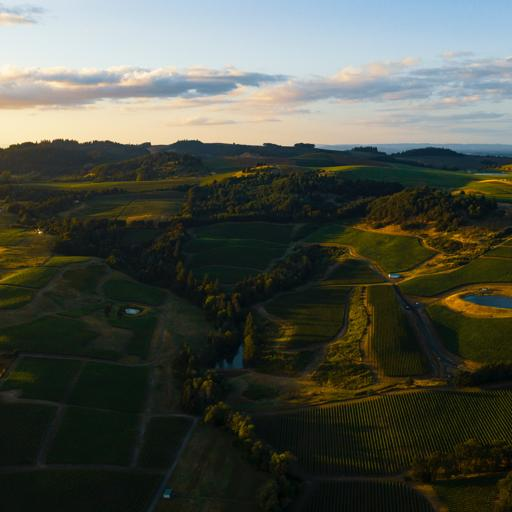

In [5]:
df = pd.read_csv(str(cfg.dataset_path / "BIQ2021.csv")).reset_index(drop=True)
random_sample = df.sample(1)
image_name = random_sample["Images"].item()
Image.open(cfg.dataset_path / "img" / image_name)

### <center> 🎛 Нормализация и аугментация картинок

<div class="alert alert-info">

Применим базовые трансформации для сборки `baseline`-решения

In [6]:
basic_transforms = T.Compose(
    [T.ToImage(), T.ToDtype(torch.float32, scale=True), T.Resize((512, 512))]
)

augmentations_train = None
augmentations_test = None

In [7]:
transforms = {
    "transforms": basic_transforms,
    "augmentations": {
        "train": augmentations_train,
        "test": augmentations_test,
    },
}

### <center> 🔥 Torch-Dataset

<div class="alert alert-info" align="center">

<img src="https://i.imgflip.com/9r0agg.jpg" align="center">

В первоначальном `csv` собран путь до файла и таргет   
Прочитаем файл `pandas` и применим трансформации

In [8]:
class BIQ2021(Dataset):
    def __init__(self, cfg, transforms: dict) -> None:
        self.df = pd.read_csv(str(cfg.dataset_path / "BIQ2021.csv")).reset_index(
            drop=True
        )
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image_name = sample["Images"]
        # Прочитаем картинку и отнормируем
        image_t = read_image(cfg.dataset_path / "img" / image_name).float() / 255
        target = sample["MOS"]
        if transforms:  # Применяем трансформации
            image_t = transforms["transforms"](image_t)
        return (image_t, target)

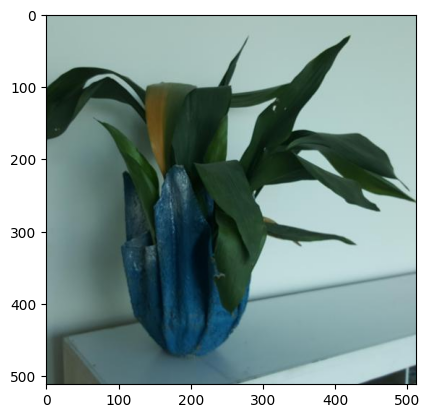

In [9]:
dataset = BIQ2021(cfg, transforms)
plt.imshow(dataset[10][0].permute(1, 2, 0))

## <center id="c6"> 🧰 Наконец DataModule!

<div class="alert alert-info">

Опять же, так как топик **Advanced** - обучать сетку будем соответствующим образом. Обучением проведем на **KFold** валидации

In [10]:
class BIQ2021DM(LightningDataModule):
    def __init__(self, dataset, cfg):
        super().__init__()
        self.dataset = BIQ2021(cfg, transforms)
        self.n_splits = cfg.n_splits
        self.batch_size = cfg.batch_size
        self.kfold = KFold(
            n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed
        )  # Задаем KFold валидацию
        self.splits = None  # Храним индексы

    def prepare_data(self):
        # Здесь сохраним индексы сплитов
        self.splits = list(self.kfold.split(np.arange(len(self.dataset))))

    def setup_fold(self, fold_index):
        # Создадим train, valid части
        train_indices, val_indices = self.splits[fold_index]
        self.train_dataset = Subset(self.dataset, train_indices)
        self.val_dataset = Subset(self.dataset, val_indices)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
        )

<div class="alert alert-success" align="center">

Хоть и `Lightning` не поддерживает кросс-валидацию по умолчанию - ее можно написать и ручками 🤗

# <center id="c4"> 🚀 Собираем ракету

## <center id="q3"> 📊 Не забываем про метрики

In [11]:
# Возьмем самые базовые метрики
basic_metrics = tm.MetricCollection(
    tm.AUROC(task="binary"),
)

# Очередная фишечка
train_metrics = basic_metrics.clone(prefix="train/")
valid_metrics = basic_metrics.clone(prefix="valid/")

## <center id="a1"> 🤖 А моделька?

<div class="alert alert-success">

Мы не Колумбы, поэтому искать ~~Америку 🦅~~ лучшие слои не будем, а возьмем вполне стандартную сетку - [ResNeXT]("https://paperswithcode.com/lib/torchvision/resnext")

In [12]:
class CustomResNext(LightningModule):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        # Модельку возьмем из модуля timm HuggingFace
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=1,
        )
        self.loss_fn = nn.MSELoss()

        self.train_metrics = train_metrics
        self.valid_metrics = valid_metrics

    def forward(self, X):
        y = self.model(X)
        y_prob = torch.sigmoid(y)
        return y_prob

    def _shared_step(self, stage, batch, batch_idx):
        X, y = batch
        y = y.view(-1, 1).float()
        preds = self.forward(X.float())

        match stage:
            case "train":
                metrics = self.train_metrics
            case "valid":
                metrics = self.valid_metrics
            case _:
                metrics = self.valid_metrics

        metrics.update(preds, y)
        loss = self.loss_fn(preds, y)
        calculated_metrics = metrics.compute()
        calculated_metrics[f"{stage}/Loss"] = loss

        self.log_dict(calculated_metrics, prog_bar=True)

        return preds, loss

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred, loss = self._shared_step("train", batch, batch_idx)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred, loss = self._shared_step("valid", batch, batch_idx)
        return loss

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred, loss = self._shared_step("test", batch, batch_idx)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=cfg.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=3
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "valid/Loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

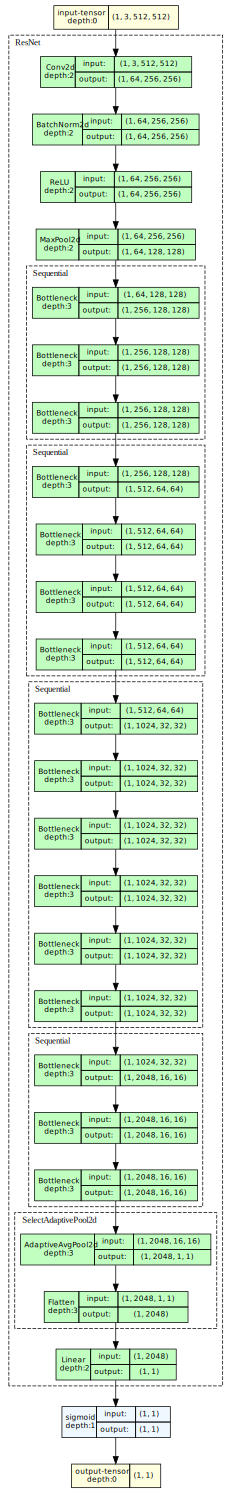

In [13]:
# Посмотрим какая модель у нас получилась
from torchview import draw_graph

model_graph = draw_graph(
    CustomResNext(), input_size=[1, 3, 512, 512], expand_nested=True
)
model_graph.visual_graph

<center>
<img src="https://memchik.ru//images/memes/5f64c564b1c7e355bc18b0a6.jpg">

# <center id="c7"> 👨‍🏫 Обучаем модель

In [16]:
# Создаем датасет
datamodule = BIQ2021DM(dataset, cfg)
datamodule.prepare_data()  # Генерируем сплиты

# Цикл кросс-валидации
for fold_idx in range(datamodule.n_splits):
    print(f"Training on fold {fold_idx + 1}/{datamodule.n_splits}")

    # Устанавливаем текущий фолд
    datamodule.setup_fold(fold_idx)

    # Создаем модель (ваша LightningModule)
    model = CustomResNext()

    # Обучаем модель на текущем фолде
    trainer = Trainer(
        accelerator="gpu",
        fast_dev_run=True,
    )
    trainer.fit(model, datamodule)

Training on fold 1/5


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.0 M | train
1 | loss_fn       | MSELoss          | 0      | train
2 | train_metrics | MetricCollection | 0      | eval 
3 | valid_metrics | MetricCollection | 0      | eval 
-----------------------------------------------------------
23.0 M    Trainable params
0         Non-trainabl

Training: |                                                                                                   …

/app/storage_local/Courses/ml_instruments/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=1` reached.


Training on fold 2/5


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.0 M | train
1 | loss_fn       | MSELoss          | 0      | train
2 | train_metrics | MetricCollection | 0      | eval 
3 | valid_metrics | MetricCollection | 0      | eval 
-----------------------------------------------------------
23.0 M    Trainable params
0         Non-trainabl

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=1` reached.


Training on fold 3/5


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.0 M | train
1 | loss_fn       | MSELoss          | 0      | train
2 | train_metrics | MetricCollection | 0      | eval 
3 | valid_metrics | MetricCollection | 0      | eval 
-----------------------------------------------------------
23.0 M    Trainable params
0         Non-trainabl

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=1` reached.


Training on fold 4/5


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.0 M | train
1 | loss_fn       | MSELoss          | 0      | train
2 | train_metrics | MetricCollection | 0      | eval 
3 | valid_metrics | MetricCollection | 0      | eval 
-----------------------------------------------------------
23.0 M    Trainable params
0         Non-trainabl

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=1` reached.


Training on fold 5/5


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | ResNet           | 23.0 M | train
1 | loss_fn       | MSELoss          | 0      | train
2 | train_metrics | MetricCollection | 0      | eval 
3 | valid_metrics | MetricCollection | 0      | eval 
-----------------------------------------------------------
23.0 M    Trainable params
0         Non-trainabl

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=1` reached.


<div class="alert alert-success">

Фух, данные, модельку собрали и обучили вроде как 😮‍💨 Так что давайте переходить к сборке нашего Pipeline'а ⛓️

# <center id="c5"> 🔗 Сборка крутого трубопровода

<div class="alert alert-info">

Для сборки `Pipeline` существует очень много фреймворков: `MLflow`, `ZenML`, `Kedro` и тп. Но изученные ранее фишки `ClearML` действуют и в этой теме: автоматическое сохранение данных, моделей, метрик и графиков. Правда удобно?

<center> "Ванечка ликует" </center>

## <center id="q4"> 🧗‍♀️ Методы создания цепочки

<div class="alert alert-success">

`ClearML` предоставляет нам 3 вида API сборки `Pipeline`:

1. **From Task**
2. **From Code**
3. **From Decorator**

<div class="alert alert-info">


**From Task** метод позволяет создавать цепочки из различных задач, которые вы запускаете ранее   

**From Code** метод создает `Pipeline` функциональным методом. То есть надо ручками прописать какой степ, за кем идет   

**From Decorator** же метод - позволяет запускать `Pipeline`, не думая какой вход и выход у функций. Вы запускаете код - `ClearML` все отловит

В ноутбуке рассмотрим функциональный метод 🤗

<div class="alert alert-info">

<center>

Наша цепочка будет выглядеть примерно так:

<img src="https://i.imgur.com/Xtah6sf.jpeg" align="center" height="500">

## <center id="c8"> 🤿 А как внедрить в код?

<div class="alert alert-success">

Если все же хотите использовать декораторы, то вам понадобится только два класса `PipelineDecorator` и `TaskTypes` - больше ничего импортировать не надо! Импорт выглядит так:

```python
from clearml.automation.controller import PipelineDecorator
from clearml import TaskTypes
```

<center> 

Собираем `Step`'ы (шаги)
</center>

Достаточно обернуть свою функцию таким образом:

```python
@PipelineDecorator.component(
    return_values=['your_parametr'], # Что возвращает функция
    task_type=TaskTypes.service, # Какой род действий
    name='super_function', # Можно переименовать степ, по дефолту - название функции 
    cache=True # Сохраняем все, что можно
)
```

Параметры:
- `return_values` - список, в котором передаем какие объекты отдает функция на выходе
- `task_type` - какую роль играет функция в `Pipeline`. [Все task_type]("https://clear.ml/docs/latest/docs/fundamentals/task#task-types")

<div class="alert alert-info">

<center> 

Собираем `Pipeline` 
</center>

Действуем аналогично - конечную функцию main или другую оборачиваем так:
```python
@PipelineDecorator.pipeline(
    name="Silver Bullet", # Название Pipeline'а
    project="Your Project", # Как называется ваш проект
    version="1.0.0", # Версионирование Pipeline'а
    skip_global_imports=True, # Если в функцию включены импорты
)
```

<div class="alert alert-info">
<center>
С теорией разобрались - переходим к практике!

<div class="alert alert-success">

Сборка Pipeline'а не занимает много времени, если вы до этого сверстали рабочую цепочку. После этого достаточно все шаги обернуть в функции

<div class="alert alert-warning">

**Важное дополнение** - перенося код в функции, добавляйте импорты в том числе - особенность ClearML 👺

In [17]:
# Созданм конфиг
def config_create():
    from dataclasses import dataclass, asdict
    from pathlib import Path

    @dataclass
    class CFG:
        project_name: str = "ML Instruments Course"
        experiment_name: str = "Meta Baseline"

        dataset_path: Path = Path("../data/BIQ2021")
        seed: int = 2024
        batch_size: int = 16
        learning_rate: float = 3e-4

        model_name: str = "resnext50_32x4d"
        pretrained: bool = True

        n_splits: int = 5

    return asdict(CFG())

In [18]:
# Загрузка данных
def data_download():
    import os

    cmd = """
    mkdir -p ../data
    mkdir -p ../data/BIQ2021
    mkdir -p ../data/BIQ2021/img

    curl -L -o ../data/biq2021.zip https://www.kaggle.com/api/v1/datasets/download/nisarahmedrana/biq2021
    unzip -d ../data/BIQ2021 -o ../data/biq2021.zip

    mv ../data/BIQ2021/*.jpg ../data/BIQ2021/img
    """
    os.system(cmd)

In [19]:
# Создание трансформаций
def transforms_create():
    import torchvision.transforms.v2 as T
    import torch

    basic_transforms = T.Compose(
        [
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
        ]
    )

    augmentations_train = None
    augmentations_test = None

    transforms = {
        "transforms": basic_transforms,
        "augmentations": {
            "train": augmentations_train,
            "test": augmentations_test,
        },
    }

    return transforms

In [20]:
# Создание датасета
def dataset_create(cfg, transforms):
    from torch.utils.data import Dataset
    import pandas as pd
    from torchvision.io import read_image

    class BIQ2021(Dataset):
        def __init__(self, cfg, transforms) -> None:
            self.cfg = cfg
            print(self.cfg)
            self.df = pd.read_csv(
                f"{self.cfg['dataset_path']}/BIQ2021.csv"
            ).reset_index(drop=True)
            self.transforms = transforms

        def __len__(self):
            return self.df.shape[0]

        def __getitem__(self, idx):
            sample = self.df.iloc[idx]
            image_name = sample["Images"]
            image_t = (
                read_image(self.cfg["dataset_path"] / "img" / image_name).float() / 255
            )
            target = sample["MOS"]
            if transforms:
                image_t = transforms["transforms"](image_t)
            return (image_t, target)

    return BIQ2021(cfg, transforms)

In [21]:
# DataModule
def datamodule_create(dataset, cfg):
    import numpy as np
    from lightning import LightningDataModule
    from sklearn.model_selection import KFold
    from torch.utils.data import Subset, DataLoader

    class BIQ2021DM(LightningDataModule):
        def __init__(self, dataset, cfg):
            super().__init__()
            self.dataset = dataset
            self.n_splits = cfg["n_splits"]
            self.batch_size = cfg["batch_size"]
            self.kfold = KFold(
                n_splits=cfg["n_splits"], shuffle=True, random_state=cfg["seed"]
            )
            self.splits = None  # Храним индексы

        def prepare_data(self):
            self.splits = list(self.kfold.split(np.arange(len(self.dataset))))

        def setup_fold(self, fold_index):
            train_indices, val_indices = self.splits[fold_index]
            self.train_dataset = Subset(self.dataset, train_indices)
            self.val_dataset = Subset(self.dataset, val_indices)

        def train_dataloader(self):
            return DataLoader(
                self.train_dataset,
                batch_size=self.batch_size,
                shuffle=True,
            )

        def val_dataloader(self):
            return DataLoader(
                self.val_dataset,
                batch_size=self.batch_size,
            )

    return BIQ2021DM(dataset, cfg)

In [22]:
# Не забываем про метрики
def metrics_create():
    import torchmetrics as tm

    basic_metrics = tm.MetricCollection(
        tm.MeanAbsolutePercentageError(),
        tm.MeanSquaredError(),
    )
    # Очередная фишечка
    train_metrics = basic_metrics.clone(prefix="train/")
    valid_metrics = basic_metrics.clone(prefix="valid/")

    return train_metrics, valid_metrics

In [23]:
# Наша модель
def model_create(train_metrics, valid_metrics):
    from lightning import LightningModule
    import timm
    import torch.nn as nn
    import torch

    class CustomResNext(LightningModule):
        def __init__(
            self,
            train_metrics,
            valid_metrics,
            model_name="resnext50_32x4d",
            pretrained=False,
        ):
            super().__init__()
            self.model = timm.create_model(
                model_name,
                pretrained=pretrained,
                num_classes=1,
            )
            self.loss_fn = nn.MSELoss()

            self.train_metrics = train_metrics
            self.valid_metrics = valid_metrics

        def forward(self, X):
            y = self.model(X)
            y_prob = torch.sigmoid(y)
            return y_prob

        def _shared_step(self, stage, batch, batch_idx):
            X, y = batch
            y = y.view(-1, 1).float()
            preds = self.forward(X.float())

            match stage:
                case "train":
                    metrics = self.train_metrics
                case "valid":
                    metrics = self.valid_metrics
                case _:
                    metrics = self.valid_metrics

            metrics.update(preds, y)
            loss = self.loss_fn(preds, y)
            calculated_metrics = metrics.compute()
            calculated_metrics[f"{stage}/Loss"] = loss

            self.log_dict(calculated_metrics, prog_bar=True)

            return preds, loss

        def training_step(self, batch, batch_idx):
            X, y = batch
            y_pred, loss = self._shared_step("train", batch, batch_idx)
            return loss

        def validation_step(self, batch, batch_idx):
            X, y = batch
            y_pred, loss = self._shared_step("valid", batch, batch_idx)
            return loss

        def test_step(self, batch, batch_idx):
            X, y = batch
            y_pred, loss = self._shared_step("test", batch, batch_idx)
            return loss

        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.1, patience=3
            )

            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "valid/Loss",
                    "interval": "epoch",
                    "frequency": 1,
                },
            }

    return CustomResNext(train_metrics, valid_metrics)

In [24]:
# Простой тренер
def trainer_create():
    from lightning import Trainer

    def trainer_fabric():
        return Trainer(accelerator="gpu", fast_dev_run=True)

    return trainer_fabric

In [25]:
# Обучение на KFold
def train_model(model, trainer_fabric, datamodule):
    datamodule.prepare_data()  # Генерируем сплиты

    # Цикл кросс-валидации
    for fold_idx in range(datamodule.n_splits):
        print(f"Training on fold {fold_idx + 1}/{datamodule.n_splits}")

        # Устанавливаем текущий фолд
        datamodule.setup_fold(fold_idx)

        # Обучаем модель на текущем фолде
        trainer = trainer_fabric()
        trainer.fit(model, datamodule)

<div class="alert alert-success">

Фух 💭 Все функции создали - давайте переходить к созданию Pipeline'а в ClearML!

# <center id="p5"> 😎 Пробуем создать свой первый Pipeline

<div class="alert alert-warning">

**Важно** - не забывайте добавить две функции `serialize`, `deserialize` - они нужны, чтобы `ClearML` смог сохранить почти любой объект

In [26]:
def serialize(obj):
    import dill

    return dill.dumps(obj)


def deserialize(bytes_):
    import dill

    return dill.loads(bytes_)

<div class="alert alert-info">

Для создания цепочки воспользуемся классом `PipelineController`. Его основные поля:

- `project` - название вашего проекта
- `name` - название Pipeline'а
- `version` - версионирование кода
- `auto_version_bump` - если уже существует версия Pipeline'а, `ClearML` самостоятельно увеличит версию. Параметр является `deprecated`
- `artifact_serialization_function`, `artifact_deserialization_function` - **ОБЯЗАТЕЛЬНЫЕ** функции!

In [27]:
from clearml import PipelineController

pipe = PipelineController(
    project="ML Instruments Course",  # Название
    name="ResNeXT BIQ2021",
    version="0.0.1",
    add_pipeline_tags=False,
    artifact_serialization_function=serialize,
    artifact_deserialization_function=deserialize,
)

ClearML Task: created new task id=61363a15078947ccb891629cbeefb0c1
2025-05-11 11:19:02,221 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/63cbc497affa4ae1b91bc71ac25a51e9/experiments/61363a15078947ccb891629cbeefb0c1/output/log
ClearML pipeline page: https://app.clear.ml/pipelines/63cbc497affa4ae1b91bc71ac25a51e9/experiments/61363a15078947ccb891629cbeefb0c1


<div class="alert alert-info">

Если вы создаете универсальный `Pipeline` для свой задачи (что очень круто 😉), то очень часто нужно быстро поменять какие-то параметры: путь до датасета, архитектура модели, кол-во эпох и тд. Для этого можно использоваться встроенный "подстановщик" параметров. Для этого можно воспользоваться следующим интерфейсом

```python
pipe.add_parameter(
    name='url', # Название переменной
    description='url to pickle file', # Краткое описание
    default='https://github.com/allegroai/events/raw/master/odsc20-east/generic/iris_dataset.pkl' # Значение параметра
)
```

<div class="alert alert-info">

Сборка же степов тоже не представляет ничего сложного 🤗
```python
pipe.add_function_step(
    name='super_step', # Название степа
    function=config_create, # Какую функцию вызываем на step'е
    function_kwargs=dict( # Можем поменять параметры функции
        # Для подстановки параметров:
        # название_параметра='${название_функции.ее_выход}'
        transforms='${transforms_create.transforms}'
        # Если задавали параметр ранее - название_функции меняется на pipeline
        cfg='${pipeline.url}',
    ),
    function_return=['foo_bar'], # Что возвращает функция
    cache_executed_step=False, # Если не хотим, чтобы сохранялся выхлоп функций
    parents=['function_1', 'function_2'] # Если явно хотите задать "родителей" функции
)
```

In [28]:
pipe.add_function_step(
    name="config_create",  # Название степа
    function=config_create,
    function_return=["cfg"],
    # cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

In [29]:
pipe.add_function_step(
    name="data_download",
    function=data_download,
    cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

In [30]:
pipe.add_function_step(
    name="transforms_create",
    function=transforms_create,
    function_return=["transforms"],
    # cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

In [31]:
pipe.add_function_step(
    name="dataset_create",
    function=dataset_create,
    function_kwargs=dict(
        cfg="${config_create.cfg}", transforms="${transforms_create.transforms}"
    ),
    function_return=["dataset"],
    # cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

In [32]:
pipe.add_function_step(
    name="datamodule_create",
    function=datamodule_create,
    function_kwargs=dict(
        dataset="${dataset_create.dataset}", cfg="${config_create.cfg}"
    ),
    function_return=["datamodule"],
    # cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

In [33]:
pipe.add_function_step(
    name="metrics_create",
    function=metrics_create,
    function_return=["train_metrics", "valid_metrics"],
    cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

In [34]:
pipe.add_function_step(
    name="model_create",
    function=model_create,
    function_kwargs=dict(
        train_metrics="${metrics_create.train_metrics}",
        valid_metrics="${metrics_create.valid_metrics}",
    ),
    function_return=["model"],
    # cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

In [35]:
pipe.add_function_step(
    name="trainer_create",
    function=trainer_create,
    function_return=["trainer_fabric"],
    # cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

In [36]:
pipe.add_function_step(
    name="train_model",
    function=train_model,
    function_kwargs=dict(
        model="${model_create.model}",
        trainer_fabric="${trainer_create.trainer_fabric}",
        datamodule="${datamodule_create.datamodule}",
    ),
    function_return=["model"],
    # cache_executed_step=False,
)

Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module
Could not fetch function declared in __main__: <module '__main__'> is a built-in module
Could not fetch function imports: <module '__main__'> is a built-in module


True

<div class="alert alert-success">

Pipeline наконец-то собрали 🦍 - давайте попробуем запуститься

<div class="alert alert-info">

Если вы пользуетесь ClearML в личных нуждах, то скорее всего вам нет смысла хостить сервер ClearML. Поэтому для запуска цепочки будет достаточно следующей команды:

In [ ]:
pipe.start_locally(run_pipeline_steps_locally=True)

<div class="alert alert-success" align="center">

Результат эксперимента в `UI ClearML`:

<img src="https://i.postimg.cc/Y9F3FT2q/2025-05-11-18-32-08.png">

# <center id="p6"> 🧸 Выводы и заключения ✅

<div class="alert alert-success">

**В этом модуле мы научились:**
- Создавать надежные цепочки для переиспользования в будущем
- Использовать различный API-интерфейс для сборки `Pipeline`'ов в любых сценариях
- Отслеживать `Pipeline`'ы в красивом UI в `ClearML`